In [6]:
import numpy as np
import pandas as pd
import pickle
import sys, os
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import plotly.express as px

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
print(module_path)

from explainability_analysis.transformer_analysis import *
from explainability_analysis.crop_spectral_signature_analysis import *
from explainability_analysis.visualization_functions import *
from explainability_analysis.visualization_constants import *
figures_base_path = os.path.join(FIGURES_BASE_PATH, "attn_weights_patterns")


def get_attn_and_signature_for_top_n_attention_dates(temporal_attn_weights, spectral_indices, sorting_column="Attention", num_dates=3, occluded_class=None):
    top_dates = sort_by_attention(temporal_attn_weights, sorting_column).iloc[:num_dates].index
    temporal_attn_weights_filtered_classes = temporal_attn_weights.loc[~temporal_attn_weights["Crop type"].isin(CLASSES_TO_EXCLUDE)]
    relevant_attn_weights = temporal_attn_weights_filtered_classes.loc[temporal_attn_weights_filtered_classes["Date"].isin(top_dates)]
    relevant_attn_weights.reset_index(inplace=True)
    print(top_dates)
    spectral_indices_copy = spectral_indices.copy(deep=True)
    spectral_indices_with_attention = pd.merge(spectral_indices_copy, relevant_attn_weights, left_on=["PARCEL_ID","Date"], right_on=["index", "Date"], how="inner")
    spectral_indices_with_attention.rename(columns={"Crop type_y": "Crop type"}, inplace=True)
    spectral_indices_with_attention["Date"] = spectral_indices_with_attention["Date"].apply(lambda x: "{:02d}-{:02d}".format(x.month, x.day))
    
    return spectral_indices_with_attention


def calc_attn_weights_corr(temporal_attention_weights, value_column):
    avg_daily_attn_weights = temporal_attention_weights.groupby(["Date", "Crop type"]).agg("mean").reset_index()
    avg_daily_attn_weights = avg_daily_attn_weights.pivot(index="Date", columns="Crop type", values=value_column)
    corr_values = avg_daily_attn_weights.corr()
    return corr_values
    
def plot_attn_weights_corr(temporal_attention_weights, plot_label, target_classes=None, show_corr_values=True, corr_value_column="Attention"):
    
    plot_data = temporal_attention_weights.copy(deep=True)
    if target_classes is not None: 
        plot_data = temporal_attention_weights.loc[temporal_attention_weights["Crop type"].isin(target_classes)]
    
    fig, axs = plt.subplots(figsize=(7, 4))
    corr_values = calc_attn_weights_corr(plot_data, corr_value_column)
    axs = sns.heatmap(corr_values,cmap="Blues", ax=axs, annot=show_corr_values)
    axs.set_ylabel('')    
    axs.set_xlabel('')
    axs.tick_params(axis='y', rotation=0)
    fig.tight_layout()
    plt.savefig(os.path.join(figure_results_path, '{}.eps'.format(plot_label)), dpi=400)
    
base_model_path = "C:/Users/results/crop-type-classification-explainability"

C:\Users\Ivica Obadic\PycharmProjects\EOExplainability


In [2]:
spectral_indices = get_dataset_spectral_indices()
temporal_attn_weights, temporal_attn_date_class_avg, avg_attention_per_obs_acq_date = get_attn_weights_patterns(base_model_path, "all_dates","1654184128", target_classes=None)

Initializing BavarianCropsDataset train partition in holl
read 12 classes
precached dataset files found at C:/Users/datasets/BavarianCrops/npy\12_classes\blocks\holl\train
Dataset C:/Users/datasets/BavarianCrops/. region holl. partition train.X:20858x(71, 16), y:(20858,) with 12 classes
Initializing BavarianCropsDataset valid partition in holl
read 12 classes
precached dataset files found at C:/Users/datasets/BavarianCrops/npy\12_classes\blocks\holl\valid
Dataset C:/Users/datasets/BavarianCrops/. region holl. partition valid.X:3909x(144, 16), y:(3909,) with 12 classes
Initializing BavarianCropsDataset test partition in holl
read 12 classes
precached dataset files found at C:/Users/datasets/BavarianCrops/npy\12_classes\blocks\holl\test
Dataset C:/Users/datasets/BavarianCrops/. region holl. partition test.X:9583x(144, 16), y:(9583,) with 12 classes
Initializing BavarianCropsDataset train partition in krum
read 12 classes
precached dataset files found at C:/Users/datasets/BavarianCrops/np

In [ ]:
plt.rcParams.update(attn_weight_matrix_viz_fonts)
attn_weights_for_parcel = get_parcel_attn_weights(base_model_path, "all_dates","1654184128", "71456779")
attn_weights_for_parcel.index = attn_weights_for_parcel.index.map(lambda x: datetime.datetime(2018, int(x.split('-')[1]), int(x.split('-')[0])))
attn_weights_for_parcel.index = attn_weights_for_parcel.index.map(lambda x: x.strftime("%b. %d"))
attn_weights_for_parcel.columns = attn_weights_for_parcel.columns.map(lambda x: datetime.datetime(2018, int(x.split('-')[1]), int(x.split('-')[0])))
attn_weights_for_parcel.columns = attn_weights_for_parcel.columns.map(lambda x:  x.strftime("%b. %d"))

fig_width = set_size(150)[0]
fig, ax_attn_weights = plt.subplots(figsize=(fig_width, 2.5))
ax_attn_weights = attn_weights_heatmap(attn_weights_for_parcel, ax_attn_weights, "binary", "Winter Barley", 18)

fig.tight_layout()
plt.savefig(os.path.join(figures_base_path, '71456779_attn_weights.png'))

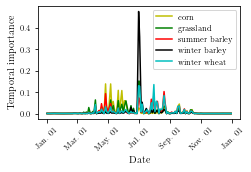

In [3]:
plt.rcParams.update(tex_fonts)
plot_attn_weights(figures_base_path, temporal_attn_date_class_avg,  target_classes = ["grassland","corn", "summer barley", "winter wheat","winter barley"], y_plot_label="Temporal importance")

In [12]:
sort_by_attention(temporal_attn_weights, "Attention")

Date
2018-07-01    0.143337
2018-07-03    0.138712
2018-05-07    0.063266
2018-04-07    0.056005
2018-05-22    0.055646
                ...   
2018-11-30    0.000142
2018-11-08    0.000128
2018-12-05    0.000120
2018-11-10    0.000092
2018-11-05    0.000061
Name: Attention, Length: 144, dtype: float64

In [7]:
num_dates_to_use = 3
attn_with_signature = get_attn_and_signature_for_top_n_attention_dates(temporal_attn_weights, spectral_indices, num_dates=num_dates_to_use)

#show the dates with highest attention first
top_attention_dates = sort_by_attention(attn_with_signature)

attn_with_signature_and_pca_per_date = []
for i, target_date in enumerate(top_attention_dates.index):
    print(target_date)
#     if target_date == "07-03":
#         continue
    relevant_attn_spectral_indices_target_date = attn_with_signature.loc[attn_with_signature["Date"] == target_date]
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(relevant_attn_spectral_indices_target_date[BANDS].values)
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    relevant_attn_spectral_indices_target_date['pca-dim-1'] = pca_result[:,0]
    relevant_attn_spectral_indices_target_date['pca-dim-2'] = pca_result[:,1]
    
    attn_with_signature_and_pca_per_date.append(relevant_attn_spectral_indices_target_date)
    
attn_with_signature_and_pca = pd.concat(attn_with_signature_and_pca_per_date)

DatetimeIndex(['2018-07-01', '2018-07-03', '2018-05-07'], dtype='datetime64[ns]', name='Date', freq=None)
07-01
Explained variation per principal component: [0.73938726 0.1953666 ]
07-03
Explained variation per principal component: [0.68650943 0.245018  ]
05-07
Explained variation per principal component: [0.81593853 0.15540365]


C:\Users\Ivica Obadic\AppData\Local\Temp\ipykernel_15664\2674563512.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_attn_spectral_indices_target_date['pca-dim-1'] = pca_result[:,0]
C:\Users\Ivica Obadic\AppData\Local\Temp\ipykernel_15664\2674563512.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_attn_spectral_indices_target_date['pca-dim-2'] = pca_result[:,1]
C:\Users\Ivica Obadic\AppData\Local\Temp\ipykernel_15664\2674563512.py:17: SettingWithCopyWarning: 
A value is trying to b

In [ ]:
fig_size = set_size(520)
g = sns.relplot(data=attn_with_signature_and_pca,
            x="pca-dim-1", y="pca-dim-2", col="Date",
            hue="Crop type", col_order=top_attention_dates.index,
            size="Attention", sizes=(1, 200),
            palette=CROP_TYPE_COLOR_MAPPING)

g.fig.set_figwidth(fig_size[0])
g.fig.set_figheight(2)
for i, ax in enumerate(g.axes.flatten()):
    date = top_attention_dates.index[i]
    date_output = datetime.datetime(2018, int(date.split('-')[0]), int(date.split('-')[1]))
    ax.set_title(date_output.strftime("%B %d"), fontweight ="bold")


g.legend.remove()
g.fig.legend(handles=g.legend.legendHandles[1:6], loc=1)

#axs.set_title("Spectral Reflectances on {}".format(target_date))
g.savefig(os.path.join(figures_base_path, 'spectral_reflectances_top_dates.png'), dpi=400)

In [ ]:
fig_size = set_size(173)
attn_with_signature_and_pca_on_date = attn_with_signature_and_pca[at]
g = sns.relplot(data=attn_with_signature_and_pca,
            x="pca-dim-1", y="pca-dim-2", col="Date",
            hue="Crop type", col_order=top_attention_dates.index,
            size="Attention", sizes=(1, 200),
            palette=CROP_TYPE_COLOR_MAPPING)

In [ ]:
for target_date in top_attention_dates.index:
    visualize_geotiff_parcels(target_date, figures_base_path, show_title=False)

In [ ]:
attn_with_signature_long = pd.melt(attn_with_signature_and_pca, id_vars=["Date", "PARCEL_ID", "Crop type"], value_vars=["Attention", "NDVI"], var_name="Metric", value_name="Value")
fig, axs = plt.subplots(figsize=(set_size(520)[0], 2.5), ncols=3, nrows=1, sharey=True)

for i, target_date in enumerate(top_attention_dates.index):
    ax_ndvi_date = axs[i]
    data_per_date = attn_with_signature_long.loc[attn_with_signature_long["Date"] == target_date]
    ax_ndvi_date = sns.barplot(x="Crop type", y="Value", hue="Metric", data=data_per_date, ax=ax_ndvi_date, ci="sd",
                          order=["grassland", "summer barley","corn", "winter wheat", "winter barley"])
    ax_ndvi_date.set_xticklabels(ax_ndvi_date.xaxis.get_ticklabels(), rotation=45, ha="right")
    date_output = datetime.datetime(2018, int(target_date.split('-')[0]), int(target_date.split('-')[1]))
    #ax_ndvi_date.set_title(date_output.strftime("%B %d"))
    if (i > 0):
        ax_ndvi_date.yaxis.set_label_text('')
        ax_ndvi_date.get_legend().remove()    

fig.tight_layout()
plt.savefig(os.path.join(figures_base_path, '{}.pdf'.format("NDVI_vs_attention")))

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from rasterio.plot import reshape_as_raster, reshape_as_image

target_parcel = 71529070
base_parcels_path = "C:/Users/datasets/BavarianCrops/parcel_visualization/parcels_over_time"

data_for_parcel = attn_with_signature_and_pca.loc[attn_with_signature_and_pca["PARCEL_ID"] == target_parcel]
data_for_parcel = data_for_parcel.sort_values(by="Date")
data_for_parcel["TIMESTAMP"] = data_for_parcel['TIMESTAMP'].dt.strftime('%B %d')
fig_width = set_size(260)[0]
fig, axs = plt.subplots(figsize=(fig_width, 2.8))
axs.set_ylim(-0.01, (max(data_for_parcel["Attention"])) + 0.2)
axs = sns.stripplot(data=data_for_parcel, x="TIMESTAMP", y="Attention", ax = axs, jitter=False)
for i in range(len(data_for_parcel.index)):
    attn_at_date = data_for_parcel.iloc[i]
    date = attn_at_date["Date"]
    tiff_image_path = os.path.join(base_parcels_path, "{}_{}.tif".format(target_parcel, date))
    image = load_tiff_image(tiff_image_path)
    image = reshape_as_image(image)
    image = OffsetImage(image, zoom=2.5)
    ab = AnnotationBbox(image, (i, attn_at_date["Attention"]  + 0.16), frameon=False)
    axs.add_artist(ab)

axs.set_xlabel('Date')
axs.set_ylabel('Temporal importance')

axs.spines.right.set_visible(False)
axs.spines.top.set_visible(False)

plt.savefig(os.path.join(figures_base_path, '{}.pdf'.format("{}_parcel_viz".format(target_parcel))))
plt.savefig(os.path.join(figures_base_path, '{}.png'.format("{}_parcel_viz".format(target_parcel))), dpi=400)